In [1]:
import pickle
import warnings

import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))
from tqdm import tqdm,trange

from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
#######


pairs = [
#   [0,0], #N0
#   [0,1], #kappa
#   [1,0], #kappa
#   [0,2], #N1
#   [1,1], #N1
#   [2,0], #N1
#    [0,3], #should vanish
#    [1,2], #should vanish
#    [2,1], #should vanish
#    [3,0], #should vanish
#    [0,4], #N2 
#    [1,3], #N2
#    [2,2], #N2
#    [3,1], #N2
#    [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]



warnings.filterwarnings("ignore")
#####

oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)
with open('f_aniso_ftot.pkl', 'rb') as f:
    ftot = pickle.load(f)
print('loaded estimated ftot')


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

# In[3]:



# In[4]:




# In[5]:


print("Map properties")

# number of pixels for the flat map
nX = 1200
nY = 1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 51  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra


# In[6]:


print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# # reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
# cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)
cmb.fCtotal = ftot # no longer reinterpolating since it seems like it leads to errors?

../data/input/universe_Planck15/camb/CAMB_outputs.pkl
loaded estimated ftot
Map properties
CMB experiment properties


In [2]:

# Determine the shape of a single data array
with open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/N1-mcmc-nBins%d-morestats-Tcombos_%d_%d-aniso.pkl'%(nBins, 0, 0), "rb") as f:
    sample_cdata = pickle.load(f)
num_rows, dim1, dim2 = sample_cdata.shape

# Initialize c_data with zeros and concatenate loaded data along the 0th axis
c_data = np.zeros((20 * 20 * num_rows, dim1, dim2))
for DATA_IDX_1 in trange(20):
    for DATA_IDX_2 in range(20):
        path = '/oak/stanford/orgs/kipac/users/delon/LensQuEst/N1-mcmc-nBins%d-morestats-Tcombos_%d_%d-aniso.pkl'%(nBins, DATA_IDX_1, DATA_IDX_2)
        with open(path, "rb") as f:
            c_data[DATA_IDX_1 * 20 * num_rows + DATA_IDX_2 * num_rows : (DATA_IDX_1 * 20 + DATA_IDX_2 + 1) * num_rows, :, :] = pickle.load(f)

print(c_data.shape)


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]

(4000000, 3, 50)


In [3]:
c_data.shape[0]/2000**2

1.0

In [4]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)
    return lCen, Cls, sCls

In [5]:
N1_mcmc = combine_Cl(c_data)

4000000 (4000000, 3, 50)


In [6]:
with open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/N1-mcmc-nBins%d-morestats-aniso.pkl'%(nBins), "wb") as f:
    pickle.dump(N1_mcmc, f)

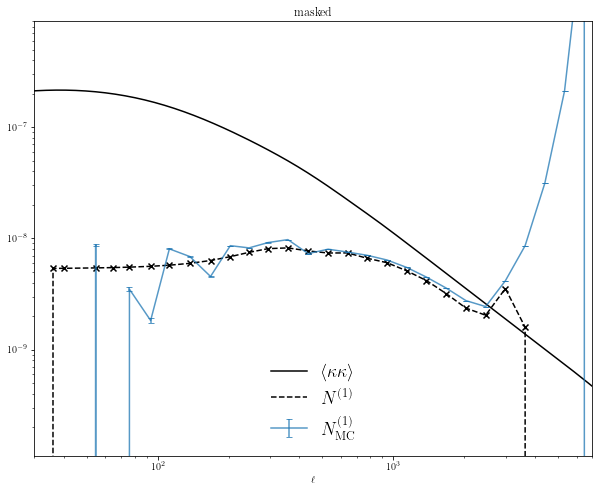

In [7]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

ell = baseMap.l.flatten()
theory=[fKK]#, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
factor = lambda x : 1
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, factor(L)*ClExpected, sty, label=l)
    
    
n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
bins = n1[0]
n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
for i in range(len(indices)):
    if(indices[i] != 'TT'):
        continue        
    n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
    KK = fKK(bins)

    phiphi =  -2. * KK / bins**2
    phiphi *=  -2./ bins**2
    phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

    pp_n1 = n1_pp

    KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
    KK_n1 *= - bins**2 / 2
    KK_n1 *= - bins**2 / 2
    f_N1 = interp1d(bins, KK_n1, kind='linear', bounds_error=False, fill_value=0.)
    a, b = baseMap.binTheoryPowerSpectrum(f_N1, nBins=nBins)

    plt.plot(a, b, 'k--', label=r'$N^{(1)}$')
#     plt.plot(a, b*2, 'k--', label=r'$N^{(1)}$ multiplicative correction')
    plt.scatter(a, b, marker='x', color='k')

    
lCen, Cl, sCl = N1_mcmc
Ipos = np.where(Cl>0)

Ineg = np.where(Cl<0)



# t0, t1 = baseMap.binTheoryPowerSpectrum(fKK, nBins=nBins)
# t2 = np.zeros_like(t1)


ax.errorbar(lCen, (Cl), yerr=sCl, alpha=.75, 
            fmt='-', capsize=3, capthick=1, label=r'$N^{(1)}_{\rm MC}$')
ax.errorbar(lCen[Ineg], (Cl[Ineg]), yerr=sCl[Ineg], alpha=.75, 
            fmt='--', capsize=3, capthick=1)#, label=r'$\left<\kappa\kappa\right>+N^{(1)}_{\rm MCMC}$')

ax.set_title('masked')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-6)
plt.savefig('figures/mcn1_2_aniso.pdf')